<img align="right" src="https://avatars2.githubusercontent.com/u/15203083?s=460&u=4a00e83c5080312ed6311d4ab0e5f8ab362b0714&v=4" width="200" height="200">

# Hi!

- I'm [Adam](https://www.adam-p-jones.com/).
    - I'm a [data scientist](https://www.linkedin.com/in/adam-p-jones/) with an interest in complex problems in healthcare.
    - Formerly a Neuroscientist at the [NIH](https://www.nih.gov/).      

- Past projects:
    - [Maternal data linkage](https://github.com/meccaLeccaHi/record_linkage)
        - Effort to improve understanding of perinatal health outcomes in California.
    - [Testing the impact of health workers in Mali](https://www.datakind.org/blog/tracking-patients-across-years-with-record-linkage)
        - Probabilistic record linkage across consecutive census survey years.

<a id="overview"></a>

Everyone in this room can be conceptualized as a series of records that have, do, or will exist.
- We begin with a birth certificate ...
- ... and end with a death certificate.
- In between, there will be medical records, school records, marriage records, bank records, arrest records, etc.

Imagine what we could learn about ourselves by integrating all of that information, from all of those different sources, into one single, cohesive story.

And, if data were perfectly clean, this would be a simple `JOIN` operation.
- <b>But it's not.</b> 
- This is why we need techniques to integrate inconsistent data.
- Those techniques will be the focus of this talk.

## Quick example

- Public health example: Joining hospital records to birth certificates.
    - What problems would occur?
        1. People change
            - Names, addresses, ...
        2. People make mistakes
            - Typos, spelling errors, nicknames, abbreviations, ...
        3. People lie
            - Age, weight, neighborhood, ...

<a id="areas"></a>
## Application areas
Data matching is not new -- well before computers, we needed to match records belonging to the same individual.
- National census
    - Governments around the world rely on census data to allocate resources appropriately.
    - RL plays an important role in improving the quality and accuracy of census data.
    - The U.S. Census Bureau has played a major role in the development of RL techniques for several decades.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Seal_of_the_United_States_Census_Bureau.svg/200px-Seal_of_the_United_States_Census_Bureau.svg.png" alt="Census Bureau seal" width="250">
</center>    

- Medicine and public health 
    - (historically referred to as _medical_ record linkage)
    - Simply consider all of the doctors, hospitals, insurance companies, and pharmacies you've interacted with and it becomes obvious why medical records are another major RL application area.
    - In addition, _longitudinally-matched records_ can provide novel insights into health outcomes, as in the example given previously.

<br>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Seattle_physician_with_patient_1999.jpg/256px-Seattle_physician_with_patient_1999.jpg" width="350" alt="Seattle physician with patient 1999" >
</center>

- Customer records
    - In order to effectively target their customers, businesses need to minimize the redundancy that tends to occur as a result of changes in name, address, etc.
    - This requires businesses to periodically remove redundant records, in order to maintain an accurate record of their customer base (often a main source of revenue) and reach those customers effectively.
    
<center>
<img src="https://upload.wikimedia.org/wikipedia/en/7/78/DB-database-icon.png" alt="DB-database-icon.png" width="250">
</center>

- Genealogy
    - Given that more than 10% of men and women were named 'John' and 'Mary' in nineteenth century England, it becomes obvious why RL is an invaluable tool for genealogical databases, some of which are now a billion-dollar industry.
    - [LDS have spent a lot of $$$ and published a few papers on RL]
    
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/a/a8/1900_census_Kershaw_Lindauer.gif" alt="1900 census Kershaw Lindauer.gif" height="480" width="456">
</center>

<a id="why"></a>
## Why do I care?

- As a society, we are producing more data than ever before. In order to make use of it, we need intelligent solutions to integrate data from disparate sources.
- Such tools play an important role in both data mining _and_ data warehousing -- using RL, we can not only improve the quality (and statistical power) of our data, but also reveal relationships not contained within any single database.

### Notebook contents
- [Overview](#overview)
    - [Quick example](#example)
    - [Application areas](#areas)
    - [Why do I care?](#why)
- [Challenges](#challenges)
    - [Missing unique identifiers](#unique)
    - [Computational complexity](#complexity)

- [Lack of training labels](#labels)
    - [Privacy](#privacy)
- [Classic record linkage](#classic)
    - [Pre-processing](#pre)
        - [Handling missing values & outliers](#handling)
        - [Segmentation](#segmentation)
        - [Phonetic encoding](#phonetic)
    - [Indexing (blocking)](#blocking)
        - [Defining blocking keys](#keys)
    - [Comparison and classification](#classification)
        - [Names](#names)
    - [Evaluation](#evaluation)
- [Demo](#demo)
    - [Comparing classifiers](#comparing)
        - [Supervised classifiers](#supervised)
        - [Unsupervised classifiers](#unsupervised)
- [Conclusions](#conclusions)
    - [Resources](#resources)

### Objectives
1. I want to make you aware of the specific, unique challenges involved with RL, so you can better appreciate why the approach includes the steps it does.
2. Second, I want to give you a snapshot of the classic record linkage approach.
3. Finally, we will go through a demo together in which we compare the performance of a variety of classification models that we'll use for RL.

<a id="challenges"></a>
# Challenges

<a id="unique"></a>
## Missing unique identifiers

In all of these cases, the challenge that we have to overcome is missing a unique identifier for the entities we are matching.
- For example, if we had perfectly accurate social security numbers for each record, the task is reduced to a straight-forward join of two databases.
- This is often not the case for multiple reasons:
    1. accurate record keeping is hard
    2. privacy is usually a concern (in some countries use of such identifiers is illegal).
- As such, in order to match records across databases, we must use common attributes shared by both databases.
    - e.g. Name, address, phone number, age
- The quality of data points such as these are notoriously low for reasons described earlier.

<a id="complexity"></a>
## Computational complexity
- As a naive approach, one might try comparing each record in one database, to each record in the other, to determine if each pair under consideration might be a match.
- The computational complexity of such an approach, however, grows quadratically ($O(N²)$) with the size of the smaller database.
- As we'll see, some nice tricks exist to reduce the size of the problem substantially.

<a id="labels"></a>
## Lack of training labels
- In the typical (supervised) machine learning approach, labeled training data is used as feedback by a statistical model during the process of training. 
- In some cases, the there is no training data that tells us if two records correspond to the same individual or not.
- This can make the evaluation of the model's matches especially challenging.


<a id="privacy"></a>
## Privacy
- Given that these records often contain sensitive personal information (such as medical/employment records), special attention must be paid to preserving this privacy via _'de-identification'_.
- This means that identifying information are often removed or encrypted, adding to the challenge of our task.
- This is especially important for academic or medical researchers using HIPAA-protected datasets for research use.

<a id="classic"></a>
# Classic record linkage
I will use 'record linkage' to refer to both the matching of records across two (or more) databases.
- This can also include the special case of _'de-duplication'_, which simply involves using the same approach* to find duplicate records in _the same_ database.

<div style="text-align: right">*De-duplication can sometimes involve matching more than 2 records within a database.</div>

Most commonly, each record refers to a real, live person (shown here).<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Akha_cropped_hires.JPG" alt="Akha cropped hires.JPG" width="120">
</center>

<b>Examples:</b>
- Customers in a business database
- Constituents in a government database
- Patients in a hospital database
> Although, sometimes the entity to be matched is a business, or some other object.

<center>
<img src="assets/rl_pipeline_figure.png" alt="RL pipeline figure" width="456">
</center>

<a id="pre"></a>
## Pre-processing
<br>
<center>
<img src="assets/record_examples.png" alt="Example records" width="700">
</center>

Records from different databases often vary wildly in their formatting conventions.
- As a result, it falls to use to ensure that the data we want to compare has been properly cleaned and standardized.
- Any inconsistencies _must_ be resolved for successful linkage.

Although the potential problems that may need to be addressed during pre-processing are too numerous to list -- we can refine the process into three major steps:
1. Removing undesired characters/words
    - Non-alphanumeric characters
    - In some cases, removing irrelevant words (_stop words_) is useful.
2. Standardize abbreviations and correct typos
    - Use hash mapping to reduce the variation of equivalent values.
3. Parsing input to create new variables (feature engineering)
    - As we'll see, parsing our raw data into it's component elements allows us to model each of them individually, often resulting in a better performing model _and_ a greater ability to make inferences about which variables are most important during classification.   

> Regardless of the specific pre-processing steps that you perform - <b>Don't over-write the original data!</b>
> - Otherwise, there is no guarantee that it can be recovered after being transformed.
> - Later, different pre-processing may be desired.
> Ideally, new copies of the data are created after each major transformation.

<a id="handling"></a>
### Handling missing values & outliers

#### Missing values
- The <b>removal of rows</b> in RL can result in fewer correctly-linked record pairs, so this option is usually avoided.
    - The exception being rows with so little information they are unlikely to be matched anyway.
- The <b>removal of columns</b> can also be detrimental to the accuracy of our linkage.
    - Even if there are many records missing a value, the records that do will still be able to use that information for matching.

#### Outliers
Smoothing or removing noisy values can also be detrimental to the accuracy of our linkage, so it is usually not applied.
- Outliers can still contain useful information.
- For example, an age of '150' could actually be a typo of '15', which would actually be fairly close in edit distance. This information would be lost if smoothing were applied.
- Our model won't see them anyway! 
    - Unusual values usually don't make it beyond the comparison vector.

<a id="segmentation"></a>
### Segmentation
We can break down many of our variables (e.g. full name) into several new variables (e.g. title, first name, last name).

<b>Rule-based</b> approaches work well for well-structured fields containing consistent information.
- Examples: regex, `if then` statements
- Unfortunately, manual approaches like these require one to invest more time, but can be quite robust with enough labor (and iterations) invested.
- Although, they will always be susceptible to unexpected variations in the data.

<b>Statistical</b> approaches work by learning probability distributions regarding how elements in a field should be broken down into its constituent tokens.
- This approach entails classification of each element in a field as a particular token.
- The most popular tool for this approach, has been <b>hidden Markov models</b>.
    - HMMs classify a given token depending on the classification of previous tokens.
    - Like any other model, they need data to run. 
    - One approach is to manually tokenize and segment a handful of input values and labeling those tokens by hand, and then use this as a training data for a segmentation model.
    - Notice, obtaining/creating data to train HMM is sometimes as much effort as assigning rules.

<a id="phonetic"></a>
### Phonetic encoding
Allows us to compare words based on the way they are spoken, rather than the way they are spelled, since the latter can be more culturally-specific.
- This involves converting a string (typically a name, in this case) into a coded representation of how it is spoken.
    - Examples: Soundex, Phonex, Fuzzy Soundex
- These de-duplicated features can be useful for 'blocking', which we'll describe in the next section.
- These approaches are linguistic in nature, and so specific to a particular language.

Ideally, after pre-processing, those same records would look something like this below.
<br>
<center>
<img src="assets/record_clean.png" alt="Example records" width="800">
</center>

- Our data now contains all attributes from both databases.
- Content has been standardized.
- Contradicting fields have been corrected
- Abbreviations have been expanded




<b>Minimally</b>, we should at least understand the number of unique values for each feature, as well as their frequency, and how many missing values each one contains.
- We will rely heavily on this information in the next stage: <i>indexing</i>.

<a id="blocking"></a>
## Indexing (blocking)
Now, we are ready to compare our records to look for a match.
- But, if we are dealing with typical databases containing, say, a million or more records -- clearly we are not capable of comparing one trillion record pairs in a reasonable* time span.

<div style="text-align: right">*Ideally, we're talking minutes to hours, not days or weeks.</div>

Like any good algorithm designer, though, we can start to think about where we can save ourselves from doing work.
- The vast majority of record comparisons will be non-matches.
- Especially so for records that are dis-similar along particular dimensions.
- So, we begin with smaller subsets of data that are very likely to contain matching records.


> For example, while matching record pairs may sometimes contain different phone numbers, they will almost never contain different genders. 
> - As a result, we can reduce the complexity of our algorithm substantially by simply comparing only records matching on gender.
>
> <center>
<img src="assets/blocking.png" alt="Blocking example" width="800">
</center>

<b><i>Blocking</i></b>, is a similar approach to indexing, which relies on a small number of such features to reduce the number of comparisons.
- 'zip code' and 'phonetically-encoded surname' are two such examples.
- For greater improvements in performance, it is common to block using <i>multiple</i> variables, in succession.

> <b>Warning!</b>: This approach does, however, sometimes miss certain matches that may, for example, contain a typo in one of the <i>blocking keys</i>.
> - In the example above, the record would not have any chance of being matched in the event that gender changed or was entered incorrectly.
> - This highlights the need for careful selection of blocking criteria.

<a id="keys"></a>
### Defining blocking keys

Given that the comparison step (covered in the next section), is the most computationally-expensive step in the RL process, proper selection of <b>blocking keys</b> can have a <i>major</i> impact on efficiency.

#### Data quality/consistency
One major consideration must be the quality of the values in the fields selected as blocking keys. 
- This refers to both their completeness and their frequency distributions.
- Ideally, the feature selected as the blocking key will be as complete as possible (few errors or missing values).

#### Number vs. size of blocks
The frequency distribution of values in a blocked feature will determine the size of the blocks that are compared.
- A <b>small number of large blocks</b> will result in a more comparisons (more computational expense), but are less likely to miss true matches.
- However, <b>large number of small blocks</b> will result in less computational expense, but are more likely to miss true matches.

For example, blocking by gender, as we did in our example earlier, would only result in blocks that were half the size of our original dataset -- not much of an improvement in quadratic time.
- Higher-cardinality variables, such as zip code, often result in blocks of appropriate size.
- Fortunately, blocking keys can be optimized just like any other hyper-parameter.

#### Parallel processing
Blocking is also an opportunity to leverage parallel processing approaches to decrease processing time, when that is applicable.

<a id="classification"></a>
## Comparison and classification

Next, the similarity between our candidate pairs is calculated by comparing several record attributes.


- Classification of each record pair into 'matches' and 'non-matches' can be performed using either a deterministic (rule-based) or probabilistic (model-based) approach.
- We'll focus on using a probabilistic approach, in which comparisons between pairs are broken down into feature vectors summarizing their agreement along multiple dimensions.

- With those feature vectors, we can apply any one of hundreds of different classification models to attempt to predict whether those records are 'matches' or not.

- Comparisons can range from simple numeric comparisons, like the difference between ages of each record, to more complex comparison functions, like 'fuzzy' string matching or distances between addresses. 
- A few examples of such comparisons are shown below.
<center>
<img src="assets/record_comparison.png" alt="Record comparison" width="600">
</center>

The result is a <b>comparison vector</b> for each pair.
- We calculated similarity using approximate comparisons for strings, [edit distance](https://en.wikipedia.org/wiki/Edit_distance) for numbers, and equivalence for Booleans.
- This <i>feature vector</i> is what we use for classification.
- With those feature vectors, we can apply any available classification models (sklearn, statsmodels, tensorflow, etc.) to attempt to predict whether those records are 'matches' or not.

<a id="names"></a>
### Names
...play a big role in RL.
- Since names are part of language, we know there are usually general rules, but those rules have lots of variability.
- e.g. 'Robert', 'Bob', 'Bobby', 'Rob', 'Roberto'

#### Very culturally-specific
- First, middle, family name is an Anglo-Saxon convention -- not representative of <i>most</i> of the world.
- Compound names are common in many other cultures (e.g. 'Santiago Ramón y Cajal')

How names change, or stay the same, depends on your culture.
- In certain cultures, first and last name are sometimes used in the reverse order. 
- For this reason, it also a good idea to include cross comparisons. 
    - For example, including a comparison of first name with last name can catch instances of their reversal.

#### Numbers
In addition to strings, RL also sometimes includes numerical comparisons.
- For example, comparing records including financial data such as income or expenses.
- As with strings, we would like to be able to calculate an approximate similarity between two values.
    Examples:
    - Maximum absolute difference
    [ADD FORMULA]
    - Maximum percentage difference
    [ADD FORMULA]
- In both cases, we end up with a value between 1.0 (perfectly similar) and 0.0 (no similarity).

#### Time
Date, age, time comparisons
We can treat time data as a special case of numerical data and use a similar approach.
- For example, the Age percentage difference
[ADD FORMULA]

#### Space
Geographical distance comparisons
As geocoding resources are becoming increasingly popular and available, it's worth mentioning that it can sometimes be utilized in RL, as well.
- Rather than simply comparing addresses, we can actually calculate the distance (latitude and longitude) between those points on Earth.
- The major bottleneck to this process, with RL in particular, is the quality of address information that is available to use for geocoding.
- If any address details are missing or erroneous, then the location data provided may be imprecise or incorrect.

Using our comparison vector, we can now classify each record pair as either a 'match' or 'non-match'.
- Given that this operation is performed on each record pair, <i>independently</i> of all other pairs, a given record may classify as a match for more than one record.

%%% Put munkres here?

<a id="evaluation"></a>
## Evaluation
Of course, we still need to determine how successful the linkage algorithm was, in terms of correctly identified pairs.
- To do so, we would prefer to have access to labeled data that can be used for validation.
- This would contain the true match status of all possible matches.

<b>Unfortunately</b>, obtaining ground-truth data is very often not possible and so other solutions must be applied.

%%% Discuss unsupervised approaches here?

In the event we <i>do</i> have labeled data, we must still contend with a formidable class imbalance, between 'match' vs 'non-match' samples.
- As a result, appropriate classification metrics must be applied.
    - Accuracy, for example, can grow very high by classifying everything as 'non-match'.
    
%%% Discuss appropriate metrics

In this talk, we'll focus on classifying record pairs as either a 'match' or 'non-match'.
- However, a third classification can sometimes be useful -- 'possible match'.
- These records can then undergo clerical review, and the classified records can then be added to the training data for your model, thus improving your classifier.
- This is very often not feasible.

<a id="demo"></a>
# Demo

For this demo, we'll use the [Python Record Linkage Toolkit](https://recordlinkage.readthedocs.io/en/latest/about.html), a very popular and well-maintained library.
- In addition, it comes with a dataset generator, the [Freely Extensible Biomedical Record Linkage](http://users.cecs.anu.edu.au/~Peter.Christen/Febrl/febrl-0.3/febrldoc-0.3/manual.html) (Febrl) package, which we'll use for a brief demo here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# record linkage toolkit
import recordlinkage as rl
from recordlinkage.datasets import load_febrl4

# metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
# load demo data (with true labels)
dfA, dfB, true_links = load_febrl4(return_links=True)

In [3]:
# dfA = dfA.iloc[:2500]
# dfB = dfB.iloc[:2500]

In [4]:
# check out dataframe A
dfA.sample(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-4649-org,jacob,watts-endresz,6,maranoa street,rubern cottage,cowra,2046,qld,19400708,4839960
rec-3383-org,blake,beelitz,26,ranken place,goodrick park,elwood,4740,nsw,19760330,8133663
rec-4785-org,imogen,miles,14,smalley circuit,tingara vlge,toorak,2259,sa,19070626,4846134


In [5]:
# check out dataframe B
dfB.sample(3)

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-4194-dup-0,leslie,nichllas,10,de little circuit,retirement xvillage,daisy hill,4802,nsw,19691231,9490741
rec-4161-dup-0,jessica,whiet,4,levi place,habitat,carlingford,6054,vic,19691105,8241849
rec-265-dup-0,hamiah,teague,46,middleton circuit,coloolivillage,matraville,4128,nws,19731030,9222441


In [6]:
# indexing step
indexer = rl.Index()
indexer.block('postcode')

candidate_links = indexer.index(dfA, dfB)

# comparison step
compare_cl = rl.Compare()

## let's imagine we are working with de-identified data and so no names or birthdates are available
# compare_cl.exact('given_name', 'given_name', label='given_name')
# compare_cl.string('surname', 'surname', method='jarowinkler', label='surname')
# compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth')

compare_cl.exact('suburb', 'suburb', label='suburb')
compare_cl.exact('state', 'state', label='state')
compare_cl.string('address_1', 'address_1', label='address_1')
compare_cl.string('address_2', 'address_2', label='address_2')

# generate feature array
features = compare_cl.compute(candidate_links, dfA, dfB)

#### Let's view an example 'match' pair.

In [7]:
record_num = np.random.randint(0, len(true_links))

In [8]:
# view record from database A
dfA[dfA.index==true_links[record_num][0]]

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1588-org,jye,humberdross,37,coles place,de cameron,kingaroy,6230,qld,19510505,8884850


In [9]:
# view record from database B
dfB[dfB.index==true_links[record_num][1]]

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-1588-dup-0,jye,humberdross,273,coles place,de cameron,kingaroy,6230,qld,19510505,8884850


In [10]:
# view feature vector from record pair
features[[ind==true_links[record_num] for ind in features.index.to_list()]]

,,suburb,state,address_1,address_2
rec_id_1,rec_id_2,,,,
rec-1588-org,rec-1588-dup-0,1,1,1.0,1.0


<a id="comparing"></a>
## Comparing classifiers

The `recordlinkage` package includes a variety of powerful [classifiers](https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html#), which we are now ready to use.
- But, now that we have our labels and training data, we are free to apply <i>any one</i> of a variety of classification tools available.
- So, let's use a handful of standard classification models included in [scikit-learn](https://scikit-learn.org/stable/), which range in complexity.

<a id="supervised"></a>
### Supervised classifiers

In [11]:
# convert labels to Booleans to work with sklearn classifiers (inefficient)
labels = [element in true_links for element in features.index.to_list()]

# Create a training and test set
X_train, X_test, y_train, y_test  = train_test_split(features, labels)

model_predictions = dict()

In [12]:
def evaluate_model(model):
    clf = model.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(np.array([['tn', 'fp'], ['fn', 'tp']]))
    print(confusion_matrix(y_test, predictions))
    print()
    print(f"F1 score: {f1_score(y_test, predictions, average='macro')}")
    return predictions

#### Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

model_predictions['logreg'] = evaluate_model(LogisticRegression(solver='lbfgs', random_state=0))

[['tn' 'fp']
 ['fn' 'tp']]
[[6157    6]
 [  32  958]]

F1 score: 0.9887381437571926


#### Naive Bayes classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB

model_predictions['nb'] = evaluate_model(MultinomialNB())

[['tn' 'fp']
 ['fn' 'tp']]
[[6154    9]
 [ 260  730]]

F1 score: 0.9115152453828316


#### Support Vector Machine

In [15]:
from sklearn.svm import SVC

model_predictions['svc'] = evaluate_model(SVC(random_state=0))

[['tn' 'fp']
 ['fn' 'tp']]
[[6162    1]
 [  13  977]]

F1 score: 0.9958757365373946


#### Random Forest classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

model_predictions['rf'] = evaluate_model(RandomForestClassifier(random_state=0))

[['tn' 'fp']
 ['fn' 'tp']]
[[6158    5]
 [  10  980]]

F1 score: 0.9955943084682117


<a id="unsupervised"></a>
### Unsupervised classifiers

#### K-means clustering

In [17]:
from sklearn.cluster import KMeans

model_predictions['kmeans'] = evaluate_model(KMeans(n_clusters=2))

[['tn' 'fp']
 ['fn' 'tp']]
[[4802 1361]
 [  27  963]]

F1 score: 0.7274485685095826


#### Expectation/Conditional Maximization Algorithm

In [18]:
from sklearn.mixture import GaussianMixture

model_predictions['ecm'] = evaluate_model(GaussianMixture(n_components=2))

[['tn' 'fp']
 ['fn' 'tp']]
[[1370 4793]
 [ 978   12]]

F1 score: 0.16303890950035832


In [19]:
# compare model performances
fpr = dict()
tpr = dict()
roc_auc = dict()

models = [
    'logreg',
      'nb',
      'svc',
      'rf',
      'kmeans', 
      'ecm']

# compute ROC curve and ROC area for each model
for model in models:
    fpr[model], tpr[model], _ = roc_curve(y_test, model_predictions[model])
    roc_auc[model] = auc(fpr[model], tpr[model])

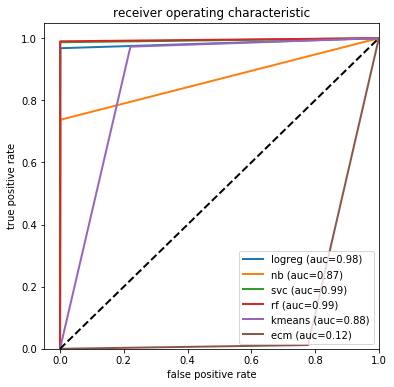

In [20]:
lw = 2
n_classes = len(model_predictions)

plt.figure(figsize=(6,6))

for key in fpr.keys():
    plt.plot(fpr[key], tpr[key], lw=lw,
             label=f'{key} (auc={roc_auc[key]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic')
plt.legend(loc='lower right')
plt.show();

<a id="conclusions"></a>
# Conclusions

1. Records on people or businesses is often very 'messy' with inconsistent formatting from one database to the next.
    - This makes finding unique matches unlikely. Instead, for each record there is a handful of plausible matches, each matching to a varying degree.


2. Typically, pre-processing is necessary in order to normalize undesired variation and ensure consistent formatting.


3. Since the naive approach has quadratic time complexity, reducing the size of the task becomes essential.
    - We do so by beginning with smaller subsets of data that are very likely to contain matching records (i.e. 'blocking').


4. Due to the expense of hand-labeling training data, we often need to use an unsupervised approach to RL.


5. In spite of our attempts to keep nice, complete databases, people still demand privacy (go figure).
    - As a result, fields that include identifying information are often removed or encrypted, adding to the challenge of our task.


6. Classification of each record pair into 'matches' and 'non-matches' can be performed using either a deterministic (rule-based) or probabilistic (model-based) approach.
    - Using a probabilistic approach, comparisons between pairs are broken down into feature vectors summarizing their agreement along multiple dimensions.
    - With those feature vectors, we can apply any one of hundreds of different classification models to attempt to predict whether those records are 'matches' or not.

<a id="resources"></a>
## Resources
- Data Matching by Peter Christen

<a href="https://www.springer.com/gp/book/9783642311635">
    <img align="center" src="https://images.springer.com/sgw/books/medium/9783642311635.jpg" width="100"alt="Data matching book">
</a>
   





- [%%WHAT ELSE?]